In [77]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy as sp
%matplotlib notebook

In [66]:
#######################
# Txt editing functions
#######################

def extract_tc(file_path):
    '''
    Extracts the tc value from the lammps log file
    '''
    with open(file_path, 'r') as file:
        content = file.read()

    # Use a specific regular expression to find the second occurrence of 'average conductivity:'
    pattern = re.compile(r'average conductivity:\s*([\d.]+)\s*\[W/mK\]', re.IGNORECASE)
    matches = pattern.findall(content)
    if len(matches)>0:
        return float(matches[0])
    else:
        return 'A kutyafáját'
    
    
def update_vseed(file_path, new_value):
    '''
    Updates the seed for the velocity command in the LAMMPS input script
    '''
    target_pattern = re.compile(r'^\s*variable\s+r\s*equal\s*[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines
    with open(file_path, 'w') as file:
        # Iterate through each line
        for line in lines:
            # Check if the line matches the target pattern
            if target_pattern.match(line):
                # Replace the number with the new value
                line = f"variable r equal {new_value}\n"
            
            # Write the line to the file
            file.write(line)
            
            
def update_mass(file_path, new_value_mass1):
    '''
    Updates the mass 1 and mass 2 in the LAMMPS input script
    '''
    # Define target patterns for mass 1 and mass 2
    target_pattern_mass1 = re.compile(r'^\s*mass\s+1\s+[\d.]+\s*$')
    # target_pattern_mass2 = re.compile(r'^\s*mass\s+2\s+[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines
    with open(file_path, 'w') as file:
        # Iterate through each line
        for line in lines:
            # Check if the line matches the target pattern for mass 1
            if target_pattern_mass1.match(line):
                # Replace the number with the new value for mass 1
                line = f"mass 1 {new_value_mass1}\n"
            
            # Write the line to the file
            file.write(line)

In [70]:
################################
# 1.) Atom type array generators
################################

def mixatom_type(size, proportion_of_ones, seed):
    
    """
    For HCP
    """
    
    N = np.product(size)
    num_ones = int(N * proportion_of_ones)
    num_twos = N - num_ones

    # Generate an array with ones and twos
    np.random.seed(seed)
    mixed_array = np.random.choice([1, 2], size=N, replace=True, p=[proportion_of_ones, 1 - proportion_of_ones])

    return mixed_array

def mixatom_type2(size, proportion_of_ones, seed):
    
    """
    For BCC
    """
    
    N = np.product(size) * 2
    num_ones = int(N * proportion_of_ones)
    num_twos = N - num_ones

    # Generate an array with ones and twos
    # np.random.seed(0) So this was silly
    np.random.seed(seed)
    mixed_array = np.random.choice([1, 2], size=N, replace=True, p=[proportion_of_ones, 1 - proportion_of_ones])

    return mixed_array

def mixatom_type3(size, proportion_of_ones, seed):
    """
    For SC
    """
    N = np.product(size)
    num_ones = int(N * proportion_of_ones)
    num_twos = N - num_ones
    
    np.random.seed(seed)
    mixed_array = np.random.choice([1, 2], size=N, replace=True, p=[proportion_of_ones, 1 - proportion_of_ones])

    return mixed_array

def layer_type(size, thickness):
    """
    Only for SC
    """
    
    N = np.product(size)
    section = size[0]*size[1]
    
    types = np.empty(N)
    
    for i in range(size[2]):
        types[thickness * section * i : thickness * section * (i+1)] = (i%2) + 1
        
    return types

def rattling_type(size, proportion_of_ones, seed):
    """
    Only for BCC
    """
    
    N = np.product(size)*2
    cage = np.ones(int(N/2))*2
    
    np.random.seed(seed)
    rattlers = np.random.choice([1, 2], size=int(N/2), replace=True, p=[proportion_of_ones*2, 1 - proportion_of_ones*2])
    types = np.hstack((cage, rattlers))
    
    return types  

#############################
# 2.) LAMMPSify main function
#############################

# LAMMPS parameter order:
# ID, group, type, charge, x, y, z


def LAMMPSify(filename, positions, type_param, type_func, size, iseed):
    N = len(positions)
    
    # Generate ID, group, type, and charge arrays
    IDs     = np.array(range(1, N+1))
    groups  = np.ones(N)
    
    types = type_func(size, type_param, iseed)
    
    charges = np.zeros(N)
    
    # Combine ID, group, type, charge with positions
    data = np.column_stack((IDs, types, positions))
    
    np.savetxt(filename, data, fmt = '%i %i %s %s %s',header = 
f'''# Title

{len(data)} atoms

{len(np.unique(data[:,1]))} atom types

0.0 {max(positions[:,0])} xlo xhi
0.0 {max(positions[:,1])} ylo yhi
0.0 {max(positions[:,2])} zlo zhi

Atoms
''', comments = '')
    
    return


def LAMMPSify_single(filename, positions, size):
    N = len(positions)
    
    # Generate ID, group, type, and charge arrays
    IDs     = np.array(range(1, N+1))
    groups  = np.ones(N)
    
    types = np.ones(N)
    
    charges = np.zeros(N)
    
    # Combine ID, group, type, charge with positions
    data = np.column_stack((IDs, types, positions))
    
    np.savetxt(filename, data, fmt = '%i %i %s %s %s',header = 
f'''# Title

{len(data)} atoms

{len(np.unique(data[:,1]))} atom types

0.0 {max(positions[:,0])} xlo xhi
0.0 {max(positions[:,1])} ylo yhi
0.0 {max(positions[:,2])} zlo zhi

Atoms
''', comments = '')
    
    return

##############################
# 3.) Atom position generators
##############################

def generate_hcp(size, parameter):
    lattice = np.array([0, 0, 0])
    
    for i in range(size[0] - 1):
        next_atom = np.array([(i+1)*parameter, 0, 0])
        lattice = np.vstack((lattice,next_atom))
        
    row1 = lattice
    row2 = row1 + np.array([0.5 * parameter, 0, 0])
    
    for i in range(size[1] - 1):
        if i%2 == 0:
            lattice = np.vstack((lattice, row2 + np.array([0, (3**0.5)/2*parameter*(i+1), 0])))
        if i%2 == 1:
            lattice = np.vstack((lattice, row1 + np.array([0, (3**0.5)/2*parameter*(i+1), 0])))
            
    layer1 = lattice
    layer2 = layer1 + np.array([0.5 * parameter, np.sqrt(3)/6 * parameter, 0])
    
    for i in range(size[2] - 1):
        if i%2 == 0:
            lattice = np.vstack((lattice, layer2 + np.array([0, 0, np.sqrt(6)/3*parameter*(i+1)])))
        if i%2 == 1:
            lattice = np.vstack((lattice, layer1 + np.array([0, 0, np.sqrt(6)/3*parameter*(i+1)])))
                                 
    return lattice

def generate_bcc(size, constant):
    sc1 = np.meshgrid(range(size[0]), range(size[1]), range(size[2]))
    sc1 = np.transpose(sc1).reshape(np.product(size), 3)
    
    sc2 = sc1 + np.array([0.5, 0.5, 0.5])
    
    bcc = np.vstack((sc1, sc2)) * constant
    
    return bcc

def generate_sc(size, constant):
    sc = np.meshgrid(range(size[0]), range(size[1]), range(size[2]))
    sc = np.transpose(sc).reshape(np.product(size), 3) * constant
    
    return sc

#########
# Plotter
#########

def plot(lattice):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the atom positions
    ax.scatter(result[:, 0], result[:, 1], result[:, 2], c='r', marker='o')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()

In [12]:
def run_bash():
    !bash {'lammps_anderson.sh'}
    return

In [30]:
# global variables

size = np.array([5, 5, 5])

np.random.seed(0)

vseed = np.random.randint(1, 10000, 2)
iseed = np.random.randint(1, 10000, 5)

atom_ratios = np.linspace(0.1, 0.9, 9)
lattice_c = 4.3
# atom_ratios = np.array([0.5])

In [31]:
# Datafile setup test

filename   = 'datafile_anderson.txt'
positions  = generate_bcc(size, lattice_c)
type_param = 0.5
type_func  = rattling_type
ratio = 0.4
ratios = [0.3, 0.4]

positions = generate_bcc(size, lattice_c)
LAMMPSify(filename, positions, 0.4, type_func, size, 13254)

In [32]:
tc_bcc = []
size = np.array([5, 5, 5])
lattice_c = 4.3

# BCC

for r in tqdm(atom_ratios):
    type_func = mixatom_type2
    for i in iseed:
        positions = generate_bcc(size, lattice_c)
        LAMMPSify(filename, positions, r, type_func, size, i)

        for j in vseed:
            update_vseed('tc_anderson.txt', j)
            run_bash()
            tc = extract_tc('log.lammps')
            tc_bcc.append(tc)

np.savetxt('tc_bcc.txt', tc_bcc)

# HCP

tc_hcp = []
size = np.array([6, 6, 6])
lattice_c = 4.0

for r in tqdm(atom_ratios):
    type_func = mixatom_type
    for i in iseed:
        positions = generate_hcp(size, lattice_c)
        LAMMPSify(filename, positions, r, type_func, size, i)

        for j in vseed:
            update_vseed('tc_anderson.txt', j)
            run_bash()
            tc = extract_tc('log.lammps')
            tc_hcp.append(tc)
            
np.savetxt('tc_hcp.txt', tc_hcp)

# SC

tc_sc = []
size = np.array([6, 6, 6])
lattice_c = 3.0

for r in tqdm(atom_ratios):
    type_func = mixatom_type3
    for i in iseed:
        positions = generate_sc(size, lattice_c)
        LAMMPSify(filename, positions, r, type_func, size, i)

        for j in vseed:
            update_vseed('tc_anderson.txt', j)
            run_bash()
            tc = extract_tc('log.lammps')
            tc_sc.append(tc)

np.savetxt('tc_sc.txt', tc_sc)

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:09:05<00:00, 460.58s/it]


<IPython.core.display.Javascript object>


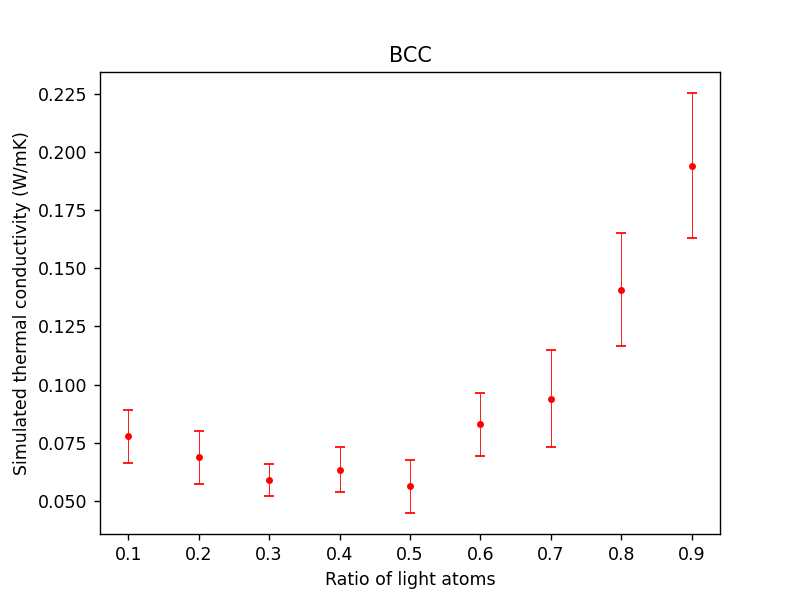

([0.0778498730849838,
  0.06878038753043025,
  0.05924455100679996,
  0.06351068233802135,
  0.056332000857110744,
  0.08302653735931592,
  0.0939282705339451,
  0.1408253650698109,
  0.1941130482291758],
 [0.011434622352800322,
  0.011286150735956743,
  0.0068831249744072225,
  0.009535333494425837,
  0.011452769397412637,
  0.013454319887209874,
  0.020778617794895766,
  0.024306934955113633,
  0.031180077037111936])

In [52]:
def plot2(arr, title):
    arr_avg = []
    err     = []
    
    arr_r = np.reshape(arr, (9, 10))
    
    for i in range(9):
        arr_avg.append(np.mean(arr_r[i]))
        err.append(np.std(arr_r[i]))
        
    plt.figure()
    plt.title(title)
    plt.xlabel('Ratio of light atoms')
    plt.ylabel('Simulated thermal conductivity (W/mK)')
    plt.errorbar(atom_ratios, arr_avg, yerr=err, fmt='.', capsize=3, c='red', linewidth=0.5)
    
    return arr_avg, err
    
plot2(tc_bcc, 'BCC')

<IPython.core.display.Javascript object>


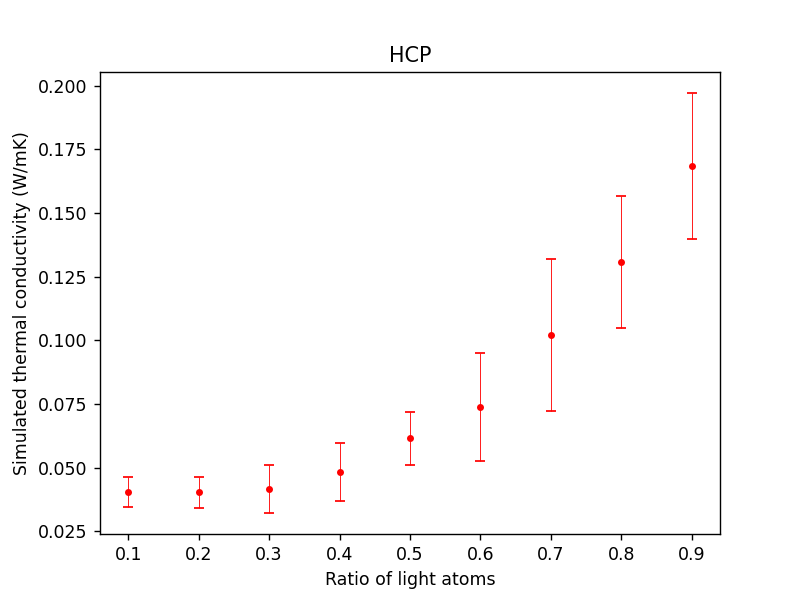

([0.04050789487228258,
  0.04030102226297236,
  0.04174180799592545,
  0.0483381948306603,
  0.061543774415892115,
  0.07387950310148202,
  0.10211162770642576,
  0.13075520845340027,
  0.16851524730235368],
 [0.0058057572729893975,
  0.005943993521709159,
  0.009521395365509179,
  0.01147549755018874,
  0.010288129406154646,
  0.021091112755266473,
  0.029799746164710938,
  0.025814509312281173,
  0.028632057303594836])

In [53]:
plot2(tc_hcp, 'HCP')

<IPython.core.display.Javascript object>


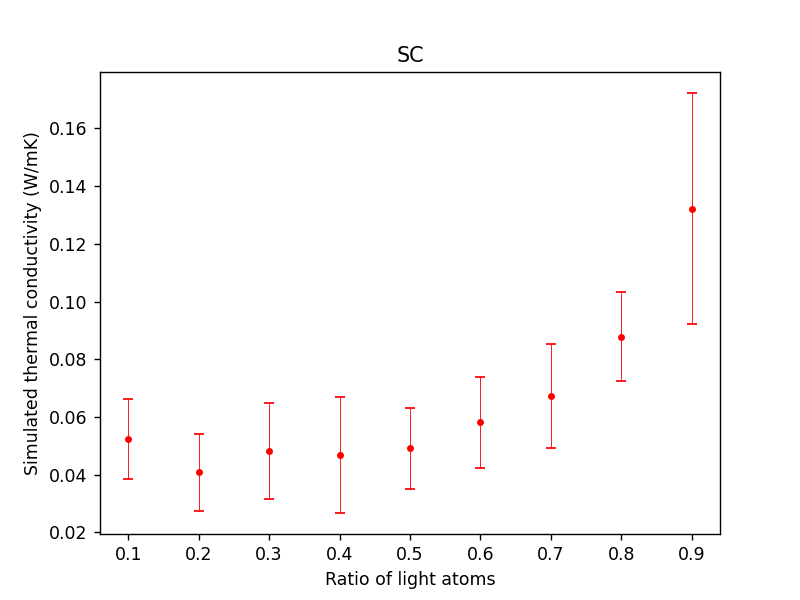

In [54]:
sc, sc_err = plot2(tc_sc, 'SC')

In [49]:
layer = np.loadtxt('layers.txt')
layer_err = np.loadtxt('layers_err.txt')

<IPython.core.display.Javascript object>


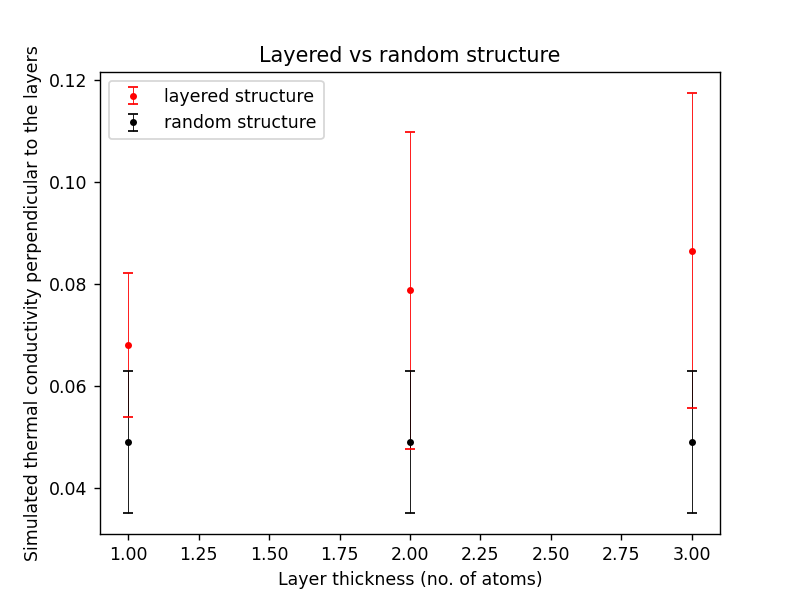

In [104]:
plt.figure()
plt.errorbar([1, 2, 3], layer[0:3], yerr = layer_err[0:3], fmt='.', capsize=3, linewidth=0.5, c='red', label='layered structure')
plt.errorbar([1, 2, 3], [sc[4], sc[4], sc[4]], yerr = sc_err[4], fmt='.', capsize=3, linewidth=0.5, c='black', label='random structure')

plt.title('Layered vs random structure')
plt.xlabel("Layer thickness (no. of atoms)")
plt.ylabel("Simulated thermal conductivity perpendicular to the layers")
plt.legend(loc='best')
plt.savefig('layer.png')

In [83]:
mass_single = np.linspace(50, 500, 6)

tc_bcc_single = []
size = np.array([5, 5, 5])
lattice_c = 4.3
positions = generate_bcc(size, lattice_c)
filename='datafile.txt'

for m in tqdm(mass_single):
    LAMMPSify_single(filename, positions, size)
    update_mass('tc_single.txt', m)
    run_bash()
    tc = extract_tc('log.lammps')
    tc_bcc_single.append(tc)
    
    
tc_hcp_single = []
size = np.array([6, 6, 6])
lattice_c = 4
positions = generate_hcp(size, lattice_c)
filename='datafile.txt'

for m in tqdm(mass_single):
    LAMMPSify_single(filename, positions, size)
    update_mass('tc_single.txt', m)
    run_bash()
    tc = extract_tc('log.lammps')
    tc_hcp_single.append(tc)
    
tc_sc_single = []
size = np.array([6, 6, 6])
lattice_c = 3
positions = generate_sc(size, lattice_c)
filename='datafile.txt'

for m in tqdm(mass_single):
    LAMMPSify_single(filename, positions, size)
    update_mass('tc_single.txt', m)
    run_bash()
    tc = extract_tc('log.lammps')
    tc_sc_single.append(tc)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:11<00:00, 51.99s/it]


In [99]:
tc_hcp_single = []
size = np.array([6, 6, 6])
lattice_c = 4
positions = generate_hcp(size, lattice_c)
filename='datafile.txt'

for m in tqdm(mass_single):
    LAMMPSify_single(filename, positions, size)
    update_mass('tc_single.txt', m)
    update_vseed('tc_single.txt', np.random.randint(1, 10000))
    run_bash()
    tc = extract_tc('log.lammps')
    tc_hcp_single.append(tc)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:08<00:00, 71.37s/it]


<IPython.core.display.Javascript object>


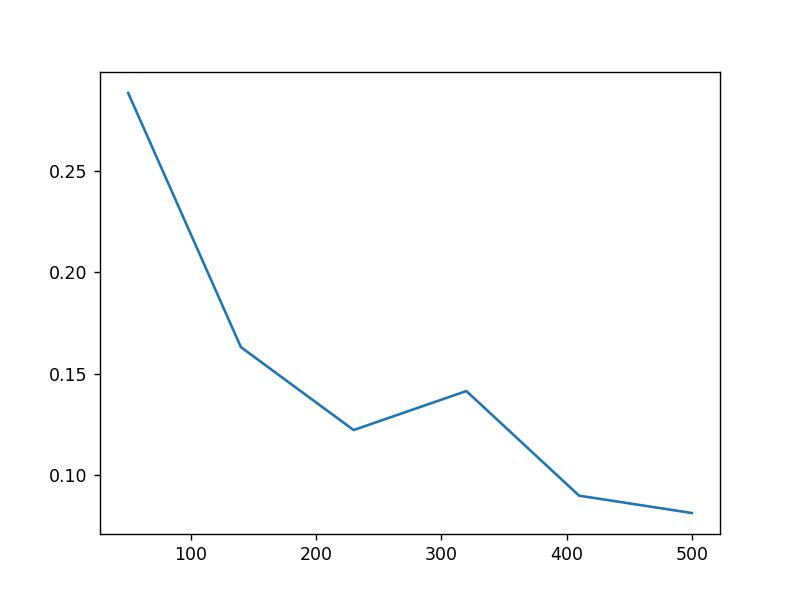

<IPython.core.display.Javascript object>


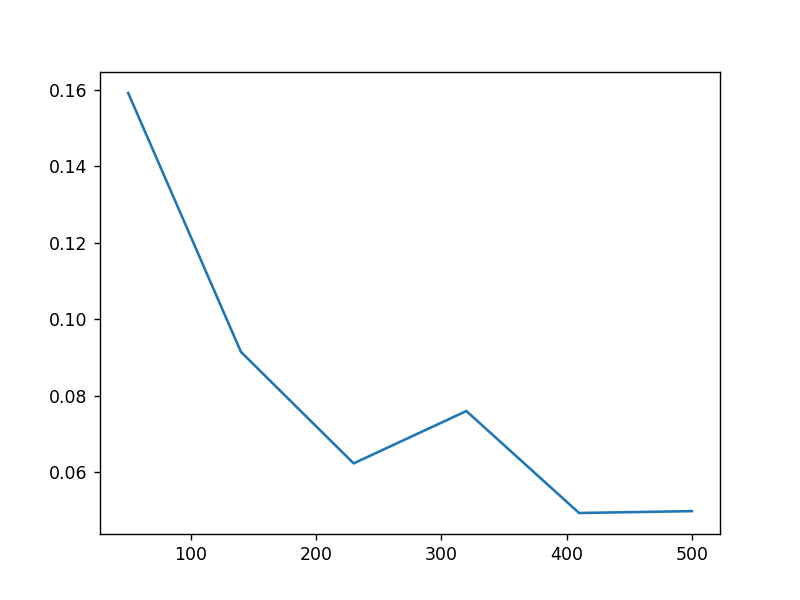

<IPython.core.display.Javascript object>


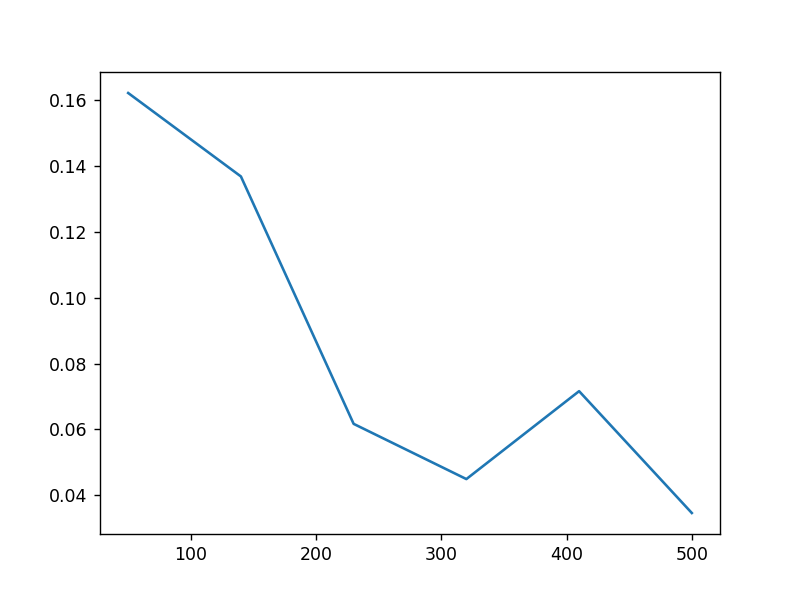

In [100]:
plt.figure()
plt.plot(mass_single, tc_bcc_single)

plt.figure()
plt.plot(mass_single, tc_hcp_single)

plt.figure()
plt.plot(mass_single, tc_sc_single)

<IPython.core.display.Javascript object>


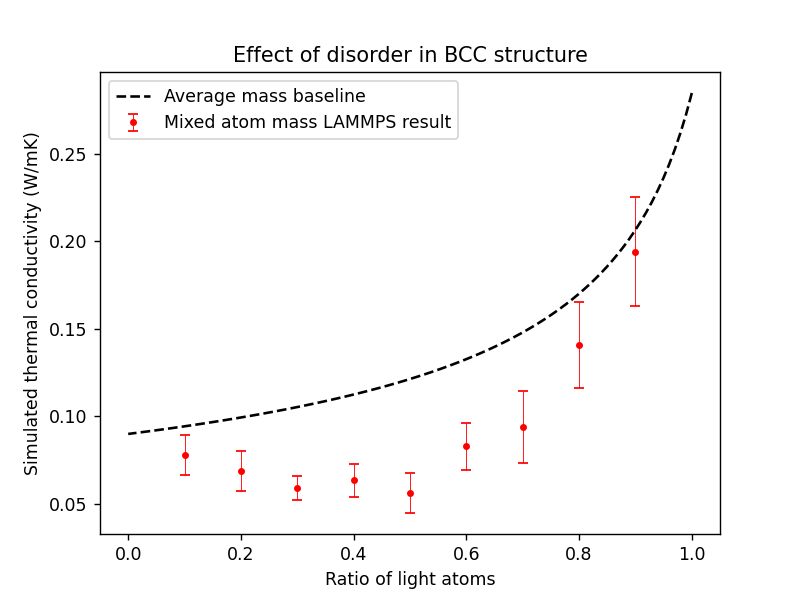

<IPython.core.display.Javascript object>


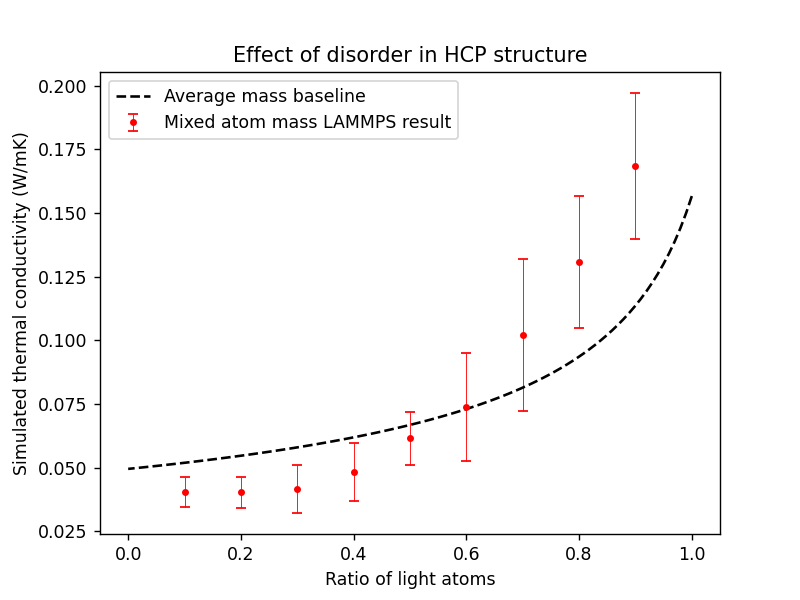

<IPython.core.display.Javascript object>


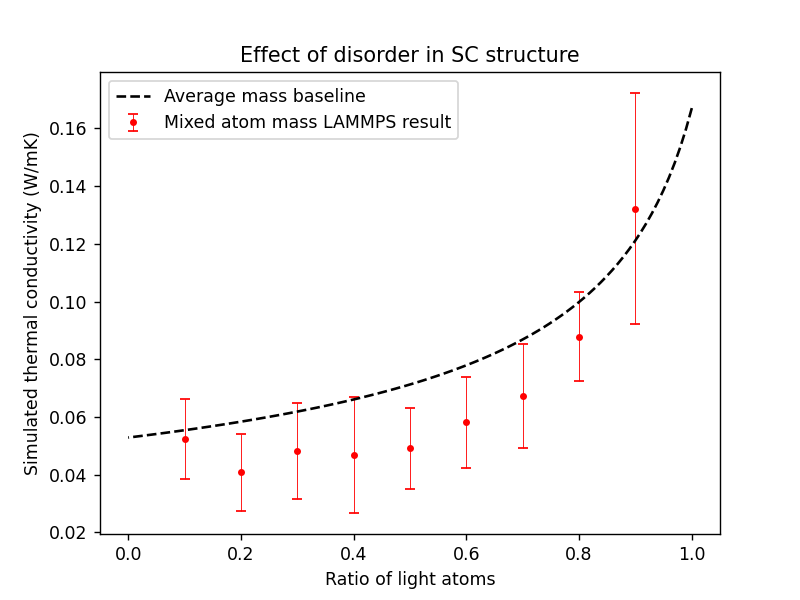

([0.05231368870025157,
  0.0407817651645222,
  0.048126565419380825,
  0.04679095804959336,
  0.04909964559681013,
  0.05812993470005998,
  0.06728006452971066,
  0.08786100349926881,
  0.13217626435741942],
 [0.013867146206745895,
  0.013284038623980466,
  0.016764340888719732,
  0.020118018344317302,
  0.013967346308447617,
  0.015768948164528805,
  0.01814559739293191,
  0.015397668585312095,
  0.04012270839789876])

In [102]:
def model1(x, c):
    return c*x**(-1/2)

def plot3(arr, title, ref, filename):
    arr_avg = []
    err     = []
        
    arr_r = np.reshape(arr, (9, 10))
    
    for i in range(9):
        arr_avg.append(np.mean(arr_r[i]))
        err.append(np.std(arr_r[i]))
        
        
    p, cov = sp.optimize.curve_fit(model1, mass_single, ref)
    
    baseline = model1(np.linspace(50, 500, 100), p[0])
    
    plt.figure()
    plt.title(title)
    plt.xlabel('Ratio of light atoms')
    plt.ylabel('Simulated thermal conductivity (W/mK)')
    plt.errorbar(atom_ratios, arr_avg, yerr=err, fmt='.', capsize=3, c='red', linewidth=0.5, label='Mixed atom mass LAMMPS result')
    plt.plot(np.flip(np.linspace(0, 1, 100)), baseline, '--', c='black', label='Average mass baseline')
    plt.legend(loc='best')
    plt.savefig(filename)
    return arr_avg, err
    
plot3(tc_bcc, 'Effect of disorder in BCC structure', tc_bcc_single, 'BCC.png')
plot3(tc_hcp, 'Effect of disorder in HCP structure', tc_hcp_single, 'HCP.png')
plot3(tc_sc, 'Effect of disorder in SC structure', tc_sc_single, 'SC.png')